In [2]:
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Column
from astropy.stats import sigma_clip
from astroquery.mast import Tesscut
from lightkurve import TessTargetPixelFile, search_targetpixelfile, search_tesscut, TessLightCurve, TessLightCurveFile, MPLSTYLE
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from random import randint, sample

## Import target list, and prepare list of TPF samples of magnitude 10

In [3]:
# Import target list
targets = ascii.read('DataInput/cluster_targets_tic.ecsv')

# Display targets in group 10-mag and show their TIC ID
current_group = 10

groups = targets['G Group']

sampletpfs = glob('DataOutput/SampleTPFs/*.fits')

# Make parallel list of target names; convert ID's into integers
sample_targets = [filename.split('_')[1] for filename in sampletpfs]

idx = targets['G Group'] == current_group
group_targets = targets[idx]['TIC ID']

# Get sample tpfs for current group of targets
# group_samples = [target for target in sample_targets if target in group_targets]
group_samples = [sampletpfs[i] for i in range(len(sample_targets)) if sample_targets[i] in group_targets]

# number of samples
n_samples = len(group_samples)

# If there are no group samples print out!
if n_samples == 0:
    print('No sample TPFs found for current group')

targets['TIC ID', 'G'][groups == current_group]

TIC ID,G
str9,float64
93267406,10.697
93268140,10.129
144997798,10.23
93912319,10.48
144996772,10.107
94107183,10.886
93268096,10.782


## Use TPF samples to get master aperture used in old light curves

In [4]:
# Assuming we got at least one sample tpf, extract their aperture masks
apertures = []
for sample in group_samples:
    print('Gathering aperture masks from sample TPF', sample)
    lcf = TessLightCurveFile(sample)
    current_aperture = lcf.hdu[2].data
    apertures.append(current_aperture)

# Generate boolean master aperture mask 
# I want to keep the mask pixels that are shared between at least two images. 
# That means that if I sum the aperture masks, I will keep the mask pixels that are above 6.
old_aperture = np.sum(apertures, axis=0) > max(6, n_samples)
old_aperture

Gathering aperture masks from sample TPF DataOutput/SampleTPFs/TESS_94107183_SEC8.fits
Gathering aperture masks from sample TPF DataOutput/SampleTPFs/TESS_93912319_SEC8.fits
Gathering aperture masks from sample TPF DataOutput/SampleTPFs/TESS_93268140_SEC8.fits
Gathering aperture masks from sample TPF DataOutput/SampleTPFs/TESS_144997798_SEC8.fits


array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False,  True,  True, False, False],
       [False, False, False,  True,  True,  True, False, False],
       [False, False, False,  True,  True,  True, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False]])

## Select a sample target from current group to work with

In [5]:
index = 6
tic_sample = targets['TIC ID'][groups == current_group][index]

In [6]:
pixelfile_all = search_tesscut(tic_sample).download_all(cutout_size=8)
print("Number of sectors observed", len(pixelfile_all))
print(f'Target {tic_sample} found in sectors:', *(tpf.sector for tpf in pixelfile_all))

Number of sectors observed 2
Target 93268096 found in sectors: 8 9


## Create new aperture for TPF of sector 8

#### Some definintions

- Old Aperture: Apertures I had manually assigned to magnitude-groups 
- New Aperture: 20% highest-count _centered_ pixels
- Old Background Aperture: 80% lowest-count pixels
- New Background Aperture: Sigma clipped 80% lowest-count pixels

In [7]:
# Get first pixel file
tpf = pixelfile_all[0]

# Define percentile identifying source in median image
percentile = 80

# Calculate median image
median_image = np.nanmedian(tpf.flux, axis=0)

# seperate the row and column of image
rows, cols = median_image.shape

# Create of Frame to Calculate distance
x, y = np.ogrid[-rows/2:rows/2, -cols/2:cols/2]

### Percentile Apeture


In [8]:
# Ones mask (idk why)
oned = np.ones(median_image.shape)

# Source masking; must be at percentile, and close to center
above_percentile = median_image > np.nanpercentile(median_image, percentile)
radius_mask = np.sqrt(x**2 + y**2) < 3
below_percentile = ~above_percentile

# Use sigma clipping on values below percentile to background improve mask
below_percentile_ma = np.ma.array(median_image, mask=above_percentile)
new_below_percentile = ~sigma_clip(below_percentile_ma, sigma=2).mask

# Define final masks
bk_mask = new_below_percentile
source_mask = above_percentile & radius_mask

# Get number of pixels in each mask
npix_ap = source_mask.sum()
npix_bk = bk_mask.sum()

# Mask in integers
maskout = oned.copy()
maskout[~source_mask] = 0

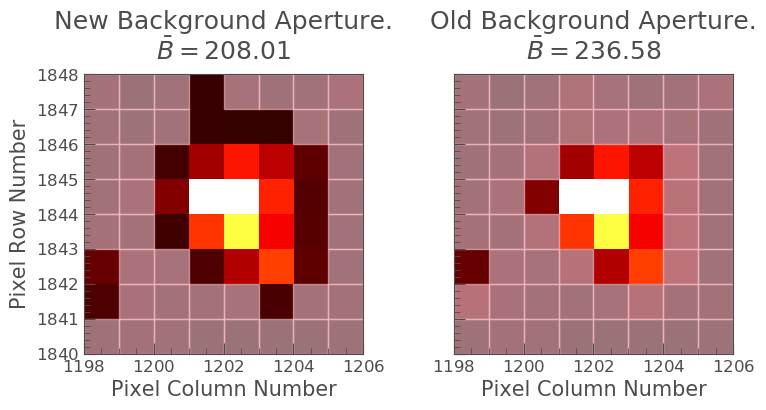

In [9]:
with plt.style.context(MPLSTYLE):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4))

# Plot target image with new aperture
tpf.plot(frame=300,interpolation="nearest",aperture_mask=bk_mask,cmap="hot", ax=ax1, show_colorbar=False)

# Plot target with old aperture
tpf.plot(frame=300,interpolation="nearest",aperture_mask=below_percentile,cmap="hot", ax=ax2, show_colorbar=False, ylabel='')

# manually set titles
with plt.style.context(MPLSTYLE):
    ax1.set_title(f'New Background Aperture.\n$\\bar{{B}}={median_image[bk_mask].mean():.2f}$')
    ax2.set_title(f'Old Background Aperture.\n$\\bar{{B}}={median_image[below_percentile].mean():.2f}$')

plt.tight_layout()

## Compare new and old apertures of target

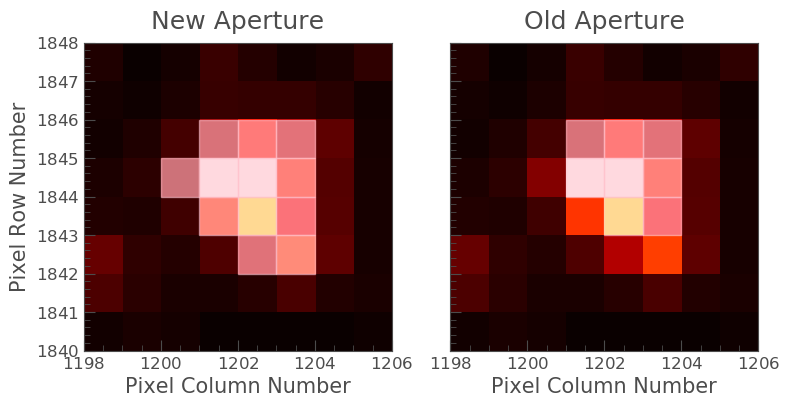

In [10]:
with plt.style.context(MPLSTYLE):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4))

# Plot target image with new aperture
tpf.plot(frame=300,interpolation="nearest",aperture_mask=source_mask,cmap="hot", ax=ax1, show_colorbar=False)

# Plot target with old aperture
tpf.plot(frame=300,interpolation="nearest",aperture_mask=old_aperture,cmap="hot", ax=ax2, show_colorbar=False, ylabel='')

# Manually set titles
with plt.style.context(MPLSTYLE):
    ax1.set_title('New Aperture')
    ax2.set_title('Old Aperture')

plt.tight_layout()

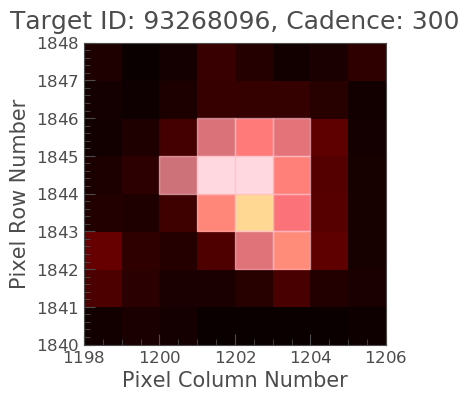

In [12]:
# Plot target image with new aperture
tpf.plot(frame=300,interpolation="nearest",aperture_mask=source_mask,cmap="hot", show_colorbar=False)
plt.gcf().savefig('new_apt.jpg', dpi=100)

## Create background-sub light curves

The background gotten from new procedure is used for both, old and new, light curves

In [38]:
# Get background light curves
new_bk = tpf.to_lightcurve(aperture_mask=bk_mask)
old_bk = tpf.to_lightcurve(aperture_mask=below_percentile)

# Count pixel numbers for old masks
npix_oldap = old_aperture.sum()
npix_oldbk = below_percentile.sum()

# Start background subtraction for new aperture light curve
new_lc = tpf.to_lightcurve(aperture_mask=source_mask)

# Calculate new background levels/errors for new aperture
new_background = new_bk.flux * npix_ap/npix_bk
new_bkerr = new_bk.flux_err * npix_ap/npix_bk

# Calculate old background levels/errors for new aperture
old_background = old_bk.flux * npix_ap/npix_oldbk
old_bkerr = old_bk.flux_err * npix_ap/npix_oldbk

# Create copy of light curve to save background-subtracted ones
new_bslc = new_lc.copy()
new_oldbslc = new_lc.copy()

# background subtract and propagate error for new ap/ new bg
new_bslc.flux -= new_background
new_bslc.flux_err = np.sqrt( new_bslc.flux_err**2 + new_bkerr**2 )

# background subtract and propagate error for new ap/ old bg
new_oldbslc.flux -= old_background
new_oldbslc.flux_err = np.sqrt( new_oldbslc.flux_err**2 + old_bkerr**2 )

################################################################

# Now use old data & proceed to background subtraction with new/old bg levels
old_lc = tpf.to_lightcurve(aperture_mask=old_aperture)

# Repeat procedure
old_bslc = old_lc.copy()
old_oldbslc = old_lc.copy()

# Calculate new background levels/errors for old aperture
new_background = new_bk.flux * npix_oldap/npix_bk
new_bkerr = new_bk.flux_err * npix_oldap/npix_bk

# Calculate old background levels/errors for old aperture
old_background = old_bk.flux * npix_oldap/npix_oldbk
old_bkerr = old_bk.flux_err * npix_oldap/npix_oldbk

old_bslc.flux -= new_background
old_bslc.flux_err = np.sqrt( old_bslc.flux_err**2 + new_bkerr**2 )

old_oldbslc.flux -= old_background
old_oldbslc.flux_err = np.sqrt( old_bslc.flux_err**2 + old_bkerr**2 )

## Plot light curves with background

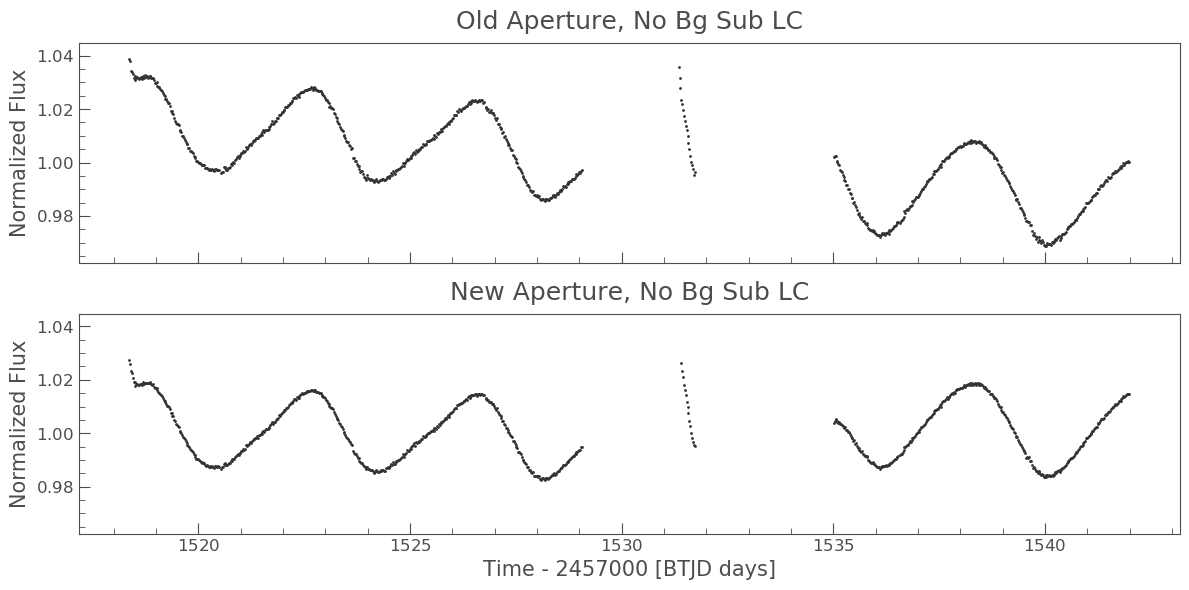

In [39]:
with plt.style.context(MPLSTYLE):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 6))

old_lc.remove_outliers(sigma=2.5).scatter(ax=ax1, xlabel='', normalize=True)
new_lc.remove_outliers(sigma=2.5).scatter(ax=ax2, normalize=True)

# Manually set titles
with plt.style.context(MPLSTYLE):
    ax1.set_title('Old Aperture, No Bg Sub LC')
    ax2.set_title('New Aperture, No Bg Sub LC')

plt.tight_layout()

## Plot [old] background subtracted light curves 

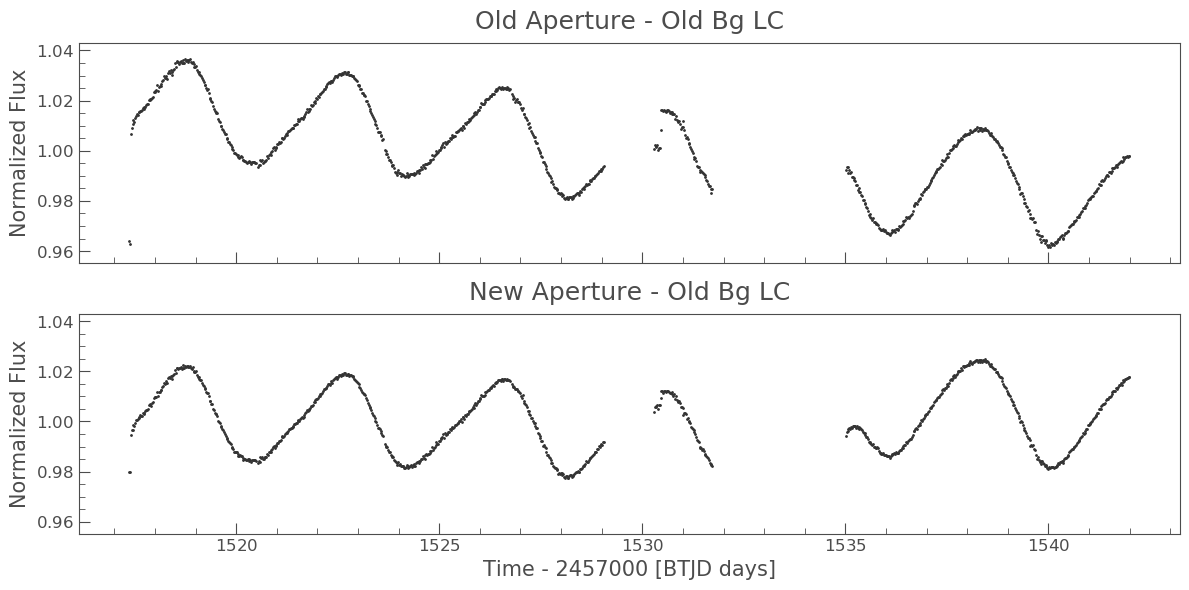

In [40]:
with plt.style.context(MPLSTYLE):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 6))

old_oldbslc.remove_outliers(sigma=2.5).scatter(ax=ax1, xlabel='', normalize=True)
new_oldbslc.remove_outliers(sigma=2.5).scatter(ax=ax2, normalize=True)

# Manually set titles
with plt.style.context(MPLSTYLE):
    ax1.set_title('Old Aperture - Old Bg LC')
    ax2.set_title('New Aperture - Old Bg LC')

plt.tight_layout()

## Plot [new] background subtracted light curves 

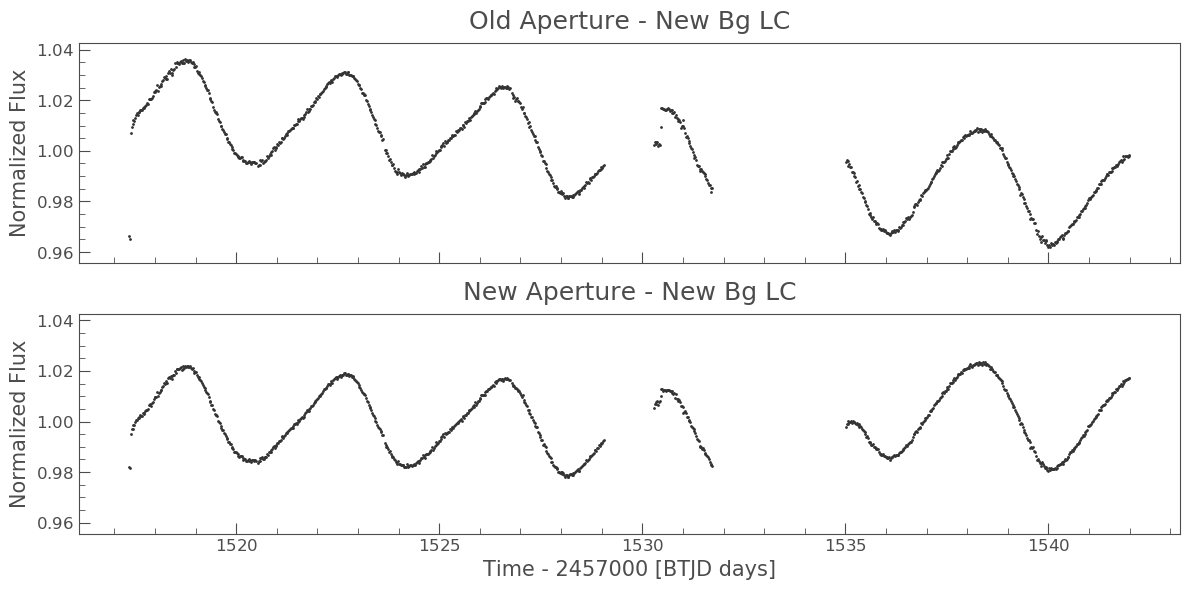

In [41]:
with plt.style.context(MPLSTYLE):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 6))

old_bslc.remove_outliers(sigma=2.5).scatter(ax=ax1, xlabel='', normalize=True)
new_bslc.remove_outliers(sigma=2.5).scatter(ax=ax2, normalize=True)

# Manually set titles
with plt.style.context(MPLSTYLE):
    ax1.set_title('Old Aperture - New Bg LC')
    ax2.set_title('New Aperture - New Bg LC')

plt.tight_layout()

# Compare new light curve with two different background levels

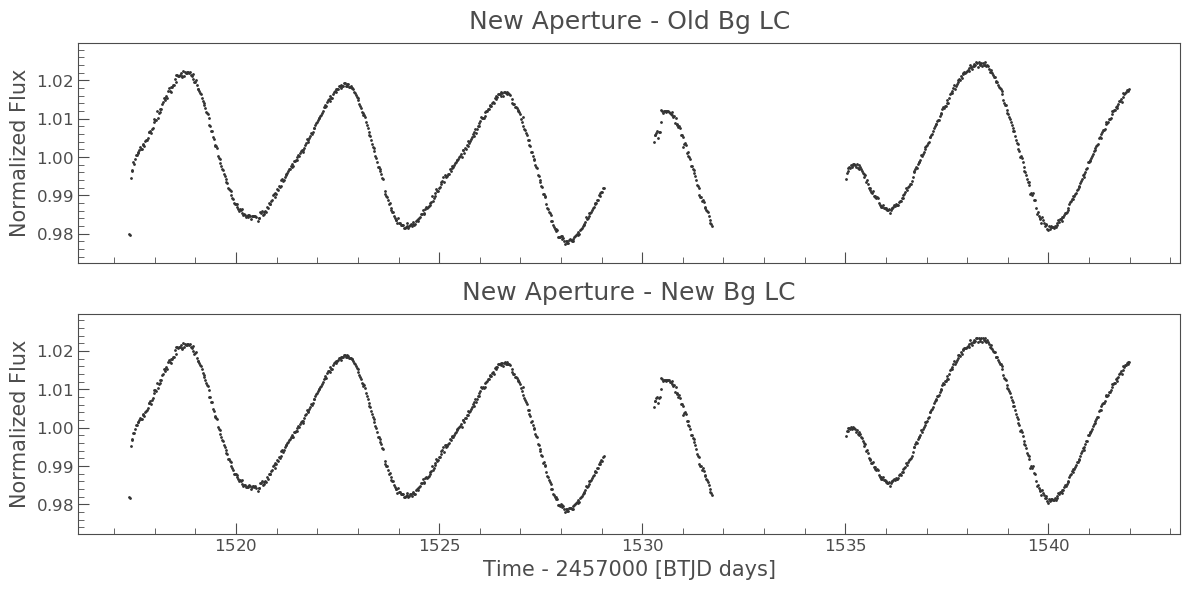

In [42]:
with plt.style.context(MPLSTYLE):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 6))

new_oldbslc.remove_outliers(sigma=2.5).scatter(ax=ax1, xlabel='', normalize=True)
new_bslc.remove_outliers(sigma=2.5).scatter(ax=ax2, normalize=True)

# Manually set titles
with plt.style.context(MPLSTYLE):
    ax1.set_title('New Aperture - Old Bg LC')
    ax2.set_title('New Aperture - New Bg LC')

plt.tight_layout()